# iml Tutorial: Interpreting black box machine learning models

In this tutorial you will learn interactively how to make black box machine learning models interpretable using the iml package

Machine learning models usually perform really well for predictions, but are not interpretable.
The iml package provides tools for analysing any black box machine learning model:

* Feature importance: Which were the most important features?

* Feature effects: How does a feature influence the prediction? (Partial dependence plots and individual conditional expectation curves)

* Explanations for single predictions: How did the feature values of a single data point affect its prediction?  (LIME and Shapley value)

* Surrogate trees: Can we approximate the underlying black box model with a short decision tree?

* The iml package works for any classification and regression machine learning model: random forests, linear models, neural networks, xgboost, etc.

This document shows you how to use the iml package to analyse machine learning models. 

If you want to learn more about the technical details of all the methods, read chapters from: https://christophm.github.io/interpretable-ml-book/agnostic.html


In [1]:
# Loading the packages
library(iml)
# We use the mlr package for training the machine learning models
library(mlr)

Loading required package: ParamHelpers


In [2]:
set.seed(1014)

We'll use the `MASS::Boston` dataset to demonstrate the abilities of the iml package. This dataset contains median house values from Boston neighbourhoods. 

In [3]:
data("Boston", package  = "MASS")
head(Boston)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


First we train a randomForest to predict the Boston median housing value:


In [4]:
lrn = makeLearner("regr.randomForest", ntree = 50)
task = makeRegrTask(data = Boston, target = "medv")
rf = train(learner = lrn, task = task)

We create a `Predictor` object, that holds the model and the data. The iml package uses R6 classes: New objects can be created by calling `Predictor$new()`.

In [5]:
X = Boston[which(names(Boston) != "medv")]
predictor = Predictor$new(rf, data = X, y = Boston$medv)

## Feature importance

We can measure how important each feature was for the predictions with `FeatureImp`. The feature importance measure works by shuffling each feature and measuring how much the performance drops. For this regression task we choose to measure the loss in performance with the mean absolute error ('mae'), another choice would be the  mean squared error ('mse').


Once we create a new object of `FeatureImp`, the importance is automatically computed. 
We can call the `plot()` function of the object or look at the results in a data.frame.

feature,importance.05,importance,importance.95,permutation.error
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
lstat,4.207455,4.238661,4.586589,4.197795
rm,3.562061,3.615389,3.702106,3.580533
nox,1.752995,1.781122,1.828999,1.763950
crim,1.701864,1.719946,1.760524,1.703364
dis,1.611596,1.650042,1.689079,1.634134
ptratio,1.565877,1.589244,1.627239,1.573922
indus,1.419416,1.446449,1.463234,1.432504
tax,1.423849,1.436202,1.455234,1.422355
age,1.355091,1.376547,1.406566,1.363276


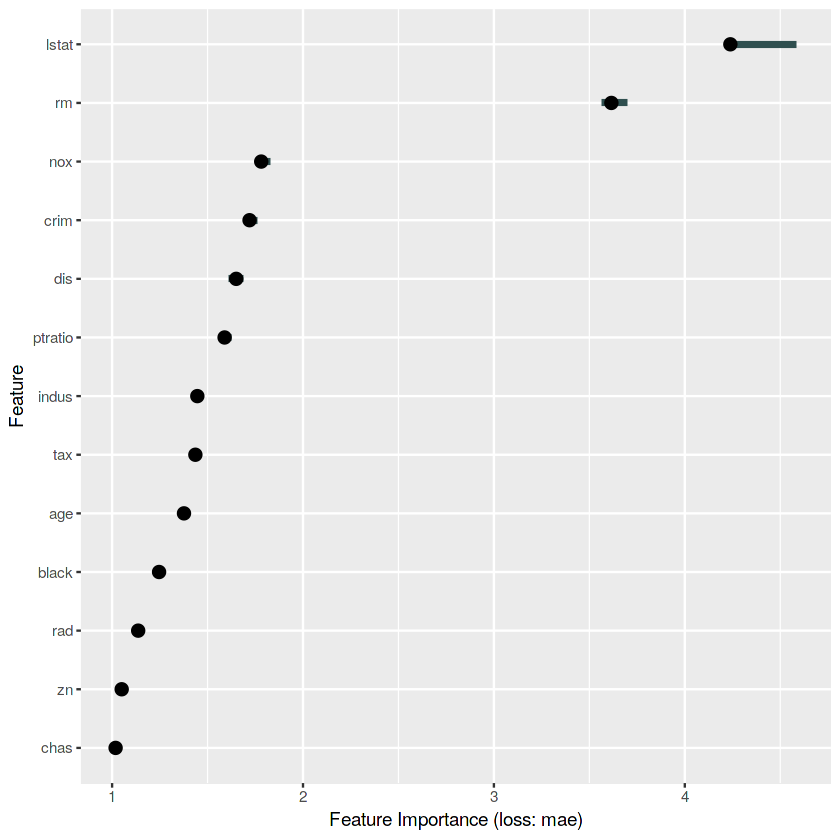

In [6]:
imp = FeatureImp$new(predictor, loss = "mae")
plot(imp)
imp$results

## Partial dependence

Besides knowing which features were important, we are interested in how the features influence the predicted outcome. The `Partial` class implements partial dependence plots and individual conditional expectation curves. Each individual line represents the predictions (y-axis) for one data point when we change one of the features (e.g. 'lstat' on the x-axis). The highlighted line is the point-wise average of the individual lines and equals the partial dependence plot. The marks on the x-axis indicates the distribution of the 'lstat' feature, showing how relevant a region is for interpretation (little or no points mean that we should not over-interpret this region).


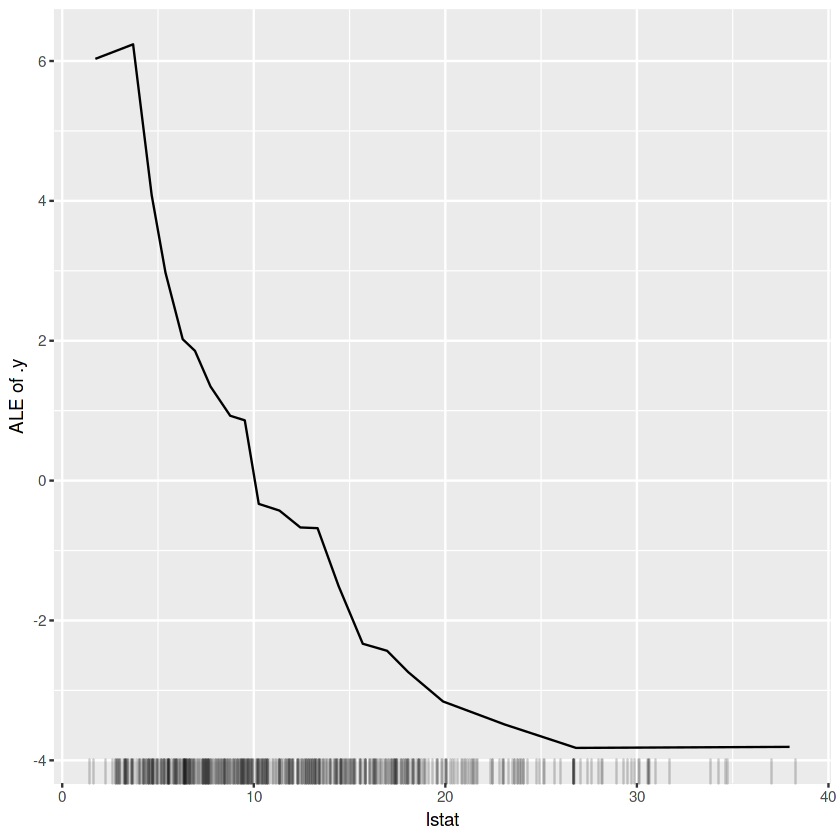

In [8]:
pdp.obj = FeatureEffect$new(predictor, feature = "lstat")
pdp.obj$plot()

If we want to compute the partial dependence curves on another feature, we can simply reset the feature:

In [ ]:
pdp.obj$set.feature("rm")
pdp.obj$plot()

We can center the curves at a feature value of our choice, which makes it easier to see the trend of the curves:


In [ ]:
pdp.obj$center(min(Boston$rm))
pdp.obj$plot()

# Feature interactions
We can also measure how strongly features interact with each other.
The interaction measure regards how much of the variance of $f(x)$ is explained by the interaction.
The measure is between 0 (no interaction) and 1 (= 100% of variance of $f(x)$ due to interactions).
For each feature, we measure how much they interact with any other feature:

In [ ]:
interact = Interaction$new(predictor)
plot(interact)

We can also specify a feature and measure all it's 2-way interactions with all other features:


In [ ]:
interact = Interaction$new(predictor, feature = "crim")
plot(interact)

## Surrogate model
Another way to make the models more interpretable is to replace the black box with a simpler model - a decision tree. We take the predictions of the black box model (in our case the random forest) and train a decision tree on the original features and the predicted outcome. 
The plot shows the terminal nodes of the fitted tree.
The maxdepth parameter controls how deep the tree can grow and therefore how interpretable it is.


In [ ]:
tree = TreeSurrogate$new(predictor, maxdepth = 2)
plot(tree)

We can use the tree to make predictions:


In [ ]:
head(tree$predict(Boston))

## Explain single predictions with a local model
Global surrogate model can improve the understanding of the global model behaviour. 
We can also fit a model locally to understand an individual prediction better. The local model fitted by `LocalModel` is a linear regression model and the data points are weighted by how close they are to the data point for wich we want to explain the prediction.


In [ ]:
lime.explain = LocalModel$new(predictor, x.interest = X[1,])
lime.explain$results
plot(lime.explain)

In [ ]:
lime.explain$explain(X[2,])
plot(lime.explain)


## Explain single predictions with game theory
An alternative for explaining individual predictions is a method from coalitional game theory named Shapley value.
Assume that for one data point, the feature values play a game together, in which they get the prediction as a payout. The Shapley value tells us how to fairly distribute the payout among the feature values.


In [ ]:
shapley = Shapley$new(predictor, x.interest = X[1,])
shapley$plot()

Re-use the object to explain other data points:


In [ ]:
shapley$explain(x.interest = X[2,])
shapley$plot()

The results in data.frame form can be extracted like this:


In [ ]:

results = shapley$results
head(results)
